# Support Vector Regressor - Demand Prediction

In this notebook we build a SVR Model for predicting the demand of the bikes per hexagon and time basket

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import geopandas
import json
from shapely.geometry import shape
from h3 import h3
from vincenty import vincenty 
from scipy import stats
warnings.filterwarnings("ignore")

In [2]:
df_demand = pd.read_csv('Data/demand_SVR.csv')

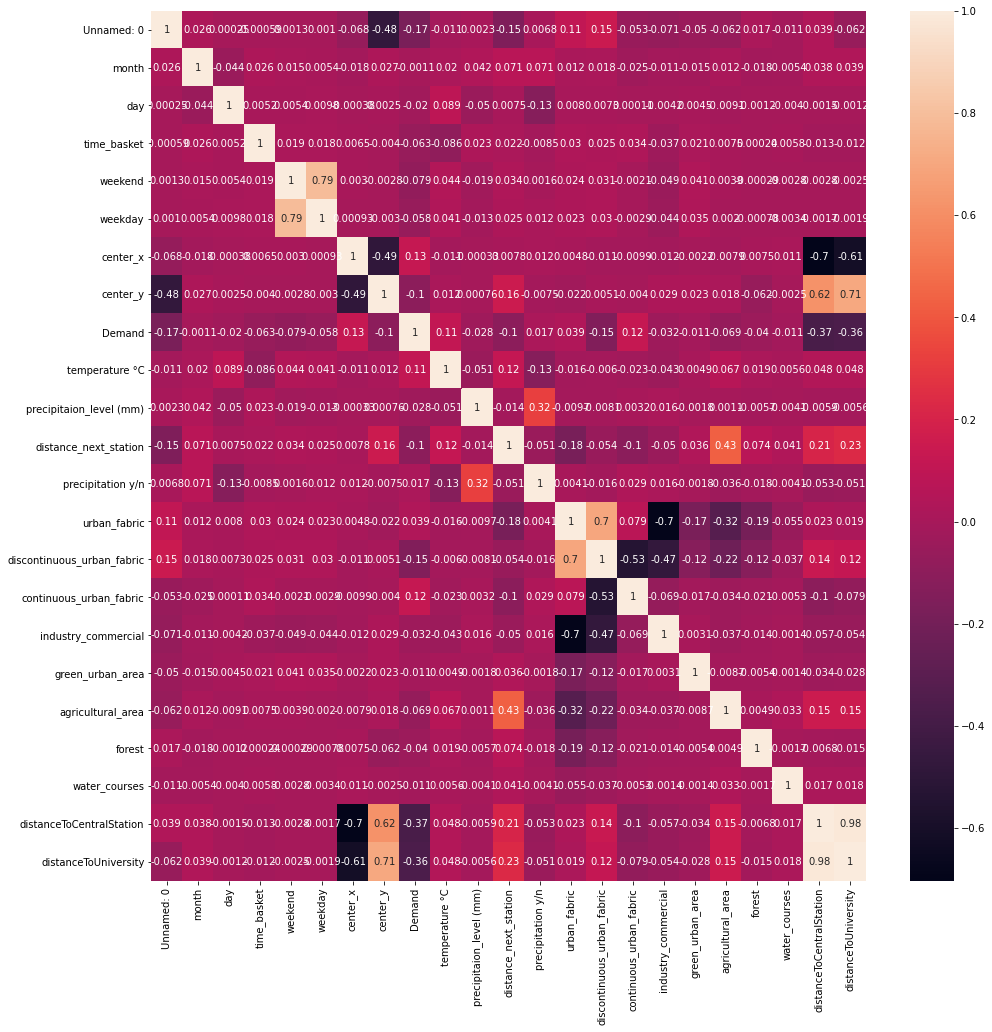

In [3]:
# get a feeling of correlations between the Demand and the other features 
plt.figure(figsize=(16, 16))
sns.heatmap(df_demand.corr(), annot=True)
plt.show()

In [4]:
df_demand.corr()[["Demand"]]

,Demand
Unnamed: 0,-0.173491
month,-0.001147
day,-0.020014
time_basket,-0.063251
weekend,-0.078818
weekday,-0.057984
center_x,0.125245
center_y,-0.100524
Demand,1.000000
temperature °C,0.108810


In [5]:
df_demand.columns

Index(['Unnamed: 0', 'h3_hex_id', 'month', 'day', 'time_basket', 'weekend',
       'weekday', 'center_x', 'center_y', 'Demand', 'temperature °C',
       'precipitaion_level (mm)', 'distance_next_station', 'precipitation y/n',
       'urban_fabric', 'discontinuous_urban_fabric', 'continuous_urban_fabric',
       'industry_commercial', 'green_urban_area', 'agricultural_area',
       'forest', 'water_courses', 'distanceToCentralStation',
       'distanceToUniversity'],
      dtype='object')

Decision for:

In [6]:
features = ["time_basket","month","center_x","center_y","day", "weekend", "weekday", "temperature °C",
            "distanceToCentralStation","distanceToUniversity","distance_next_station",
            "urban_fabric","industry_commercial", "green_urban_area"]

# SVR with ... 
* Hexagon resolution = 7 
* time baskets: 
    * 5.00 to 10.59 : Morning
    * 11.00 to 12.59 : noon
    * 13.00 to 17.59 : afternoon
    * 18.00 to 22.59 : evening
    * 23.00 to 4.59 : night

In [36]:
def runSVR(featureList,kernel="rbf",C=1,epsilon=0.1, gamma="scale"): 
    X = df_demand[featureList]
    y = df_demand[["Demand"]]
    X_train , X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=0)
    
    scaler = StandardScaler()

    svr = SVR(kernel,C=C,epsilon=epsilon,gamma=gamma)
    svr.fit(scaler.fit_transform(X_train), y_train)
    y_pred = svr.predict(scaler.fit_transform(X_train))

    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    
    print('ON TRAINING DATA', '\n',
          'R2: ', "{:.2f}".format(r2), '\n',
          'MAE: ', "{:.2f}".format(mae),'\n',
          'MSE: ',  "{:.2f}".format(mse),'\n',
          'RMSE: ', "{:.2f}".format(rmse))    
    
    y_pred = svr.predict(scaler.fit_transform(X_test))

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print('ON TEST DATA', '\n',
          'R2: ',  "{:.2f}".format(r2), '\n',
          'MAE: ',  "{:.2f}".format(mae),'\n',
          'MSE: ',  "{:.2f}".format(mse),'\n',
          'RMSE: ', "{:.2f}".format(rmse))    

In [33]:
# first simple SVR without setting any hyperparameter 
runSVR(features)

ON TRAINING DATA 
 R2:  	 0.38 
 MAE:  	 14.50 
 MSE:  	 1144.63 
 RMSE:  	 33.83
ON TEST DATA 
 R2:  	 0.41 
 MAE:  	 14.85 
 MSE:  	 1082.82 
 RMSE:  	 32.91


Metrics/ results on Training Data are close to the results on the Test Data --> Model is not overfitted

# Grid Search

In [39]:
# first grid search

X = df_demand[features]
y = df_demand[["Demand"]]

gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.5, 1, 5, 10],
            'gamma': [0.1, 0.5, 1, 5, 10]
        },
        cv=3, scoring="r2", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 10, 'epsilon': 10, 'gamma': 0.1}

In [43]:
# after first grid search

# set the features that are found by grid search
runSVR(featureList=features,C=10,epsilon=10,gamma=0.1)

ON TRAINING DATA 
 R2:  0.58 
 MAE:  12.57 
 MSE:  781.76 
 RMSE:  27.96
ON TEST DATA 
 R2:  0.62 
 MAE:  13.05 
 MSE:  699.25 
 RMSE:  26.44


--> Results get much better after hyperparameter optimization 

In [45]:
# second grid search
# scoring: neg_mean_absolute_error

X = df_demand[features]
y = df_demand[["Demand"]]

# second try 
gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="neg_mean_absolute_error", verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 15, 'epsilon': 5, 'gamma': 0.05}

In [46]:
# after second grid search
# scoring on MAE

runSVR(features,C=15,epsilon=5,gamma=0.05)

ON TRAINING DATA 
 R2:  0.54 
 MAE:  12.56 
 MSE:  860.80 
 RMSE:  29.34
ON TEST DATA 
 R2:  0.57 
 MAE:  12.96 
 MSE:  775.92 
 RMSE:  27.86


--> MAE gets better

In [47]:
# second grid search
# scoring: r2

X = df_demand[features]
y = df_demand[["Demand"]]

# second try 
gsc = GridSearchCV(
        estimator=SVR("rbf"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="r2", verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 15, 'epsilon': 15, 'gamma': 0.1}

In [48]:
# after second grid search
# scoring on r2

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.59 
 MAE:  13.66 
 MSE:  761.53 
 RMSE:  27.60
ON TEST DATA 
 R2:  0.63 
 MAE:  14.13 
 MSE:  679.82 
 RMSE:  26.07


In [19]:
# third try (Sigmoid)

X = df_demand[features]
y = df_demand[["Demand"]]

gsc = GridSearchCV(
        estimator=SVR("sigmoid"),
        param_grid={            
            'C': [1, 10,15],
            'epsilon': [5, 10,15],
            'gamma': [0.01,0.05,0.1]
        },
        cv=3, scoring="neg_mean_absolute_error", verbose=0, n_jobs=-1)
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_
best_params

{'C': 1, 'epsilon': 5, 'gamma': 0.01}

In [20]:
# after third grid search

runSVR(features,kernel="sigmoid",C=1, epsilon=5, gamma=0.01)


 R2:  0.06823150682324186 
 Mean absolute error:  19.11097037399256 
 Mean squared error:  1702.2971577487467


--> Sigmoid as kernel leads to much worse results 

## Varying Hexagon resolution and time baskets 

First of all, we create a function (prepareDemandData) that does all the necessary steps for the preparation of the demand dataframe for different hexagon resolutions and time baskets. 

In [44]:
# read in transformed trip data 
bonn_trips = pd.read_csv("Data/bonn_trips.csv", index_col=0)

# drop columns that were created in Data Preparation / new hexagon resolutions will be created below 
bonn_trips.drop(["h3_hex_id"],axis=1, inplace =True) 

In [5]:
# calculate the centers of the hexagons to use this information for further Support Verctor Regressions 
def centroid(h3hexId):
    vertexes = h3.h3_to_geo_boundary(h3hexId)
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return _x, _y

In [6]:
# returns a time basket 
def get_timebasket(hour):
    #from 5.00 to 10.59 : Morning
    if hour>4 and hour<11:
        x=0        
    #from 11.00 to 12.59 : noon
    if hour>10 and hour<13:
        x=1        
    #from 13.00 to 17.59 : afternoon
    if hour>12 and hour<18:
        x=2        
    #from 18.00 to 22.59 : evening
    if hour>17 and hour<23:
        x=3        
    #from 23.00 to 4.59 : night
    if (hour>22 and hour<25)or hour<5:
        x=4
    return x


In [72]:
def prepareDemandData(hex_resolution=8, periodLength=6, trips=bonn_trips): 
    """
    periodLength = 24h / 6h / 2h / 1h
    hex_resolution = 5 / 6 / 7 / 8 / 9 
    """
    trips["h3_hex_id"] = trips.apply(lambda row: h3.geo_to_h3(row["latitude_start"], row["longitude_start"], 
                                                                        hex_resolution) if (row['latitude_start'] and row['longitude_start']) else 0, axis=1)
    
    trips["center"] = trips["h3_hex_id"].apply(lambda x: centroid(x))
    trips["center_x"] = trips["center"].apply(lambda x: x[0])
    trips["center_y"]  = trips["center"].apply(lambda x: x[1])
    
    trips['time_basket'] = trips['hour'].apply(lambda x: x//periodLength+1)
    
    # grouped dataframe by following feature - 
    # sums up the number of trips for each hex, month, day, timebasket 
    grouped_trips = pd.DataFrame(trips.groupby(['h3_hex_id','month', 'day',"time_basket", "weekend", "weekday","center_x","center_y"], as_index = False).size())
    grouped_trips.rename({0:"Demand"},axis=1, inplace=True )
    grouped_trips.reset_index(inplace=True)

    # grouped dataframe to calculate the mean of the temperatur and the distance to the next station per day and timebasket 
    grouped_weather = pd.DataFrame(trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).mean())
    grouped_weather.reset_index(inplace=True)
    grouped_weather = grouped_weather[['time_basket', 'h3_hex_id', 'month', 'day',"temperature °C","precipitaion_level (mm)","distance_next_station"]]

    # grouped dataframe to get "precipitation y/n" for the group
    grouped_rain_bool = pd.DataFrame(trips.groupby(['time_basket', 'h3_hex_id', 'month', 'day'], as_index = False).max())
    grouped_rain_bool.reset_index(inplace=True)
    grouped_rain_bool = grouped_rain_bool[['time_basket', 'h3_hex_id', 'month', 'day',"precipitation y/n"]]
    
    # group by hex, month, day and timebasket 
    # use the value for the land features that occurs most often within one group
    grouped_land_use = pd.DataFrame(trips.groupby(['h3_hex_id','month', 'day', 'time_basket'], as_index = False)
                                    ['urban_fabric', 'discontinuous_urban_fabric', 'continuous_urban_fabric','industry_commercial', 
                                     'green_urban_area', 'agricultural_area', 'forest', 'water_courses'].agg(lambda x:x.value_counts().index[0]))
    grouped_land_use.reset_index(inplace=True,drop=True)

    # merge mean temperature with the demands 
    df_demand = grouped_trips.merge(grouped_weather, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # merge to get value for precipitation as a boolean value 
    df_demand = df_demand.merge(grouped_rain_bool, on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # merge to get the correct values for the land features
    df_demand = df_demand.merge(grouped_land_use,on=['time_basket', 'h3_hex_id', 'month', 'day'], how="inner")

    # final dataframe to predict the demand per hexagon, ... 
    df_demand["weekend"] = df_demand["weekend"].apply(lambda x : 1 if x else 0)

    # fill incorrect values with mean values of the corresponding month
    temp_means = df_demand[df_demand["temperature °C"] >= -25].groupby(["month"]).mean()[["temperature °C"]]
    for i, row in df_demand.iterrows():     
        if row["temperature °C"] < -25: # lowest temperature in Germany in 2019 was about -20° Celsius 
            df_demand.at[i, "temperature °C"] = temp_means.iloc[row["month"]]     

    # create new feature for better prediction results 
    # distances from the center of the hexagons to the CentralStation / University 
    df_demand["distanceToCentralStation"] = df_demand[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.731944, 7.096944]), axis=1)
    df_demand["distanceToUniversity"] = df_demand[["center_x","center_y"]].apply(
        lambda x: vincenty([x[0], x[1]], [50.72682, 7.0888]), axis=1)        
    
    return df_demand
    

## SVR with ... 
* Hexagon resolution = 5 

In [54]:
# period length = 1
df_demand = prepareDemandData(hex_resolution=5,periodLength=1,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.35 
 MAE:  20.59 
 MSE:  3989.20 
 RMSE:  63.16
ON TEST DATA 
 R2:  0.32 
 MAE:  21.39 
 MSE:  4924.41 
 RMSE:  70.17


In [55]:
# period length = 2
df_demand = prepareDemandData(hex_resolution=5,periodLength=2,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.44 
 MAE:  35.56 
 MSE:  10243.66 
 RMSE:  101.21
ON TEST DATA 
 R2:  0.42 
 MAE:  38.43 
 MSE:  12168.88 
 RMSE:  110.31


In [56]:
# period length = 6
df_demand = prepareDemandData(hex_resolution=5,periodLength=6,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.52 
 MAE:  90.85 
 MSE:  54706.21 
 RMSE:  233.89
ON TEST DATA 
 R2:  0.56 
 MAE:  90.94 
 MSE:  52473.28 
 RMSE:  229.07


In [57]:
# period length = 24
df_demand = prepareDemandData(hex_resolution=5,periodLength=24,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.44 
 MAE:  374.03 
 MSE:  574302.91 
 RMSE:  757.83
ON TEST DATA 
 R2:  0.37 
 MAE:  414.39 
 MSE:  740884.81 
 RMSE:  860.75


## SVR with... 
* Hexagon resolution = 6 

In [58]:
# period length = 1
df_demand = prepareDemandData(hex_resolution=6,periodLength=1,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.44 
 MAE:  14.01 
 MSE:  1356.15 
 RMSE:  36.83
ON TEST DATA 
 R2:  0.46 
 MAE:  14.11 
 MSE:  1215.51 
 RMSE:  34.86


In [59]:
# period length = 2
df_demand = prepareDemandData(hex_resolution=6,periodLength=2,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.54 
 MAE:  19.44 
 MSE:  3346.51 
 RMSE:  57.85
ON TEST DATA 
 R2:  0.59 
 MAE:  19.20 
 MSE:  2441.97 
 RMSE:  49.42


In [51]:
# period length = 6
df_demand = prepareDemandData(hex_resolution=6,periodLength=6,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.64 
 MAE:  40.64 
 MSE:  15061.13 
 RMSE:  122.72
ON TEST DATA 
 R2:  0.62 
 MAE:  42.38 
 MSE:  16216.26 
 RMSE:  127.34


In [60]:
# period length = 24
df_demand = prepareDemandData(hex_resolution=6,periodLength=24,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.50 
 MAE:  185.63 
 MSE:  213654.66 
 RMSE:  462.23
ON TEST DATA 
 R2:  0.53 
 MAE:  194.26 
 MSE:  202583.93 
 RMSE:  450.09


## SVR with... 
* Hexagon resolution = 7

In [61]:
# period length = 1
df_demand = prepareDemandData(hex_resolution=7,periodLength=1,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  -0.02 
 MAE:  10.52 
 MSE:  178.75 
 RMSE:  13.37
ON TEST DATA 
 R2:  -0.06 
 MAE:  10.47 
 MSE:  157.66 
 RMSE:  12.56


In [62]:
# period length = 2
df_demand = prepareDemandData(hex_resolution=7,periodLength=2,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.41 
 MAE:  10.49 
 MSE:  286.03 
 RMSE:  16.91
ON TEST DATA 
 R2:  0.45 
 MAE:  10.33 
 MSE:  230.79 
 RMSE:  15.19


In [53]:
# period length = 6
df_demand = prepareDemandData(hex_resolution=7,periodLength=6,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.61 
 MAE:  15.33 
 MSE:  1066.12 
 RMSE:  32.65
ON TEST DATA 
 R2:  0.64 
 MAE:  15.15 
 MSE:  866.12 
 RMSE:  29.43


In [63]:
# period length = 24
df_demand = prepareDemandData(hex_resolution=7,periodLength=24,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.70 
 MAE:  42.76 
 MSE:  7158.37 
 RMSE:  84.61
ON TEST DATA 
 R2:  0.69 
 MAE:  43.07 
 MSE:  7207.60 
 RMSE:  84.90


## SVR with...
* Hexagon resolution = 8

In [64]:
# period length = 1
df_demand = prepareDemandData(hex_resolution=8,periodLength=1,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  -8.31 
 MAE:  11.62 
 MSE:  143.32 
 RMSE:  11.97
ON TEST DATA 
 R2:  -8.30 
 MAE:  11.62 
 MSE:  143.16 
 RMSE:  11.96


In [65]:
# period length = 2
df_demand = prepareDemandData(hex_resolution=8,periodLength=2,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  -2.11 
 MAE:  9.94 
 MSE:  115.02 
 RMSE:  10.72
ON TEST DATA 
 R2:  -1.98 
 MAE:  9.95 
 MSE:  116.54 
 RMSE:  10.80


In [66]:
# period length = 6
df_demand = prepareDemandData(hex_resolution=8,periodLength=6,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.25 
 MAE:  8.70 
 MSE:  134.03 
 RMSE:  11.58
ON TEST DATA 
 R2:  0.22 
 MAE:  8.80 
 MSE:  140.50 
 RMSE:  11.85


In [67]:
# period length = 24
df_demand = prepareDemandData(hex_resolution=8,periodLength=24,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  0.61 
 MAE:  12.98 
 MSE:  511.85 
 RMSE:  22.62
ON TEST DATA 
 R2:  0.57 
 MAE:  12.95 
 MSE:  560.95 
 RMSE:  23.68


## SVR with...
* Hexagon resolution = 9

In [68]:
# period length = 1
df_demand = prepareDemandData(hex_resolution=9,periodLength=1,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  -86.81 
 MAE:  13.61 
 MSE:  186.96 
 RMSE:  13.67
ON TEST DATA 
 R2:  -87.63 
 MAE:  13.61 
 MSE:  186.98 
 RMSE:  13.67


In [69]:
# period length = 2
df_demand = prepareDemandData(hex_resolution=9,periodLength=2,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  -38.03 
 MAE:  13.11 
 MSE:  175.09 
 RMSE:  13.23
ON TEST DATA 
 R2:  -39.19 
 MAE:  13.11 
 MSE:  174.98 
 RMSE:  13.23


In [70]:
# period length = 6
df_demand = prepareDemandData(hex_resolution=9,periodLength=6,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  -6.63 
 MAE:  10.59 
 MSE:  122.31 
 RMSE:  11.06
ON TEST DATA 
 R2:  -6.84 
 MAE:  10.56 
 MSE:  121.15 
 RMSE:  11.01


In [71]:
# period length = 24
df_demand = prepareDemandData(hex_resolution=9,periodLength=24,trips=bonn_trips)

runSVR(features,C=15,epsilon=15,gamma=0.1)

ON TRAINING DATA 
 R2:  -0.55 
 MAE:  9.86 
 MSE:  126.76 
 RMSE:  11.26
ON TEST DATA 
 R2:  -0.58 
 MAE:  9.86 
 MSE:  126.10 
 RMSE:  11.23
